In [1]:
import os, sys, time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = 6, 4

sns.set(rc={"figure.figsize": (6, 4)})
# sns.set(style="darkgrid")

print("Numpy version:", np.version.version)

# Set working dir to project root
while not os.getcwd().endswith("lmc"):
    os.chdir(os.pardir)

Numpy version: 1.23.5


In [2]:
%load_ext autoreload
%autoreload 2

## Training / testing loops

In [3]:
from IPython.display import clear_output
from typing import Sequence

from src.modules import Indexer, IndexedModel

def train_epoch(model, optimizer, scheduler = None):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in trainloader:
        data = x_batch.to(device)
        target = y_batch.to(device)

        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion_train(output, target)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        with torch.no_grad():
            pred = torch.max(output, 1)[1]
    #         target = torch.max(target, 1)[1]
            acc = (pred == target).cpu().numpy().mean()
            acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model, dataloader):
    loss_log, acc_log = [], []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            data = x_batch.to(device)
            target = y_batch.to(device)

            output = model(data)
            loss = criterion_test(output, target)

            pred = torch.max(output, 1)[1].cpu().numpy()
            acc = np.mean(pred == target.cpu().numpy())
            acc_log.append(acc)

            loss = loss.item()
            loss_log.append(loss)
    return np.mean(loss_log), np.mean(acc_log)

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title("{}".format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker="+", s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()
    
def train(n_epochs, model, opt, scheduler = None):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, scheduler)

        val_loss, val_acc = test(model, validloader)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(trainset) / batch_size
        val_log.append((steps * (epoch + 1), val_loss))
        val_acc_log.append((steps * (epoch + 1), val_acc))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title="accuracy")
        print("Epoch {} valid accuracy = {:.2%}".format(epoch, val_acc_log[-1][1]))
            
    evaluate(model)

def evaluate(model):
    print("Accuracy: {:.2%}".format(test(model, testloader)[1]))

def collect_statistics(models: Sequence[IndexedModel], full: bool = False):
    if full:
        untracked_keys = set()
        for model in models:
            for key, module in model.modules.items():
                if not module.track_activations:
                    untracked_keys.add(key)
                    module.track_activations = True
    
    for model in models:
        model.eval()
        model.reset_statistics()
        model.start_tracking()
    with torch.no_grad():
        for x_batch, _ in activation_loader:
            data = x_batch.to(device)
            for model in models:
                model(data)
    
    for model in models:
        model.stop_tracking()
    
    if full:
        for key in untracked_keys:
            for model in models:
                model[key].track_activations = False

## Models

In [4]:
from src.models import ResNet, resnet18_permutation_spec

## Permutation methods

### Permutation utils

In [5]:
from src.utils import set_random_seed, interpolate, Timer
from src.rebasin import match_activations, match_weights, match_weights_sinkhorn, \
    repair, repair_closed, repair_sphere, repair_trainmode

### Sinkhorn direct (Mid, Rnd)

In [6]:
from src.modules import IndexedModel
from src.models import SinkhornRebasinModel
from src.permutation_specs import PermutationSpec, \
    apply_permutation

def sinkhorn_direct(model0: IndexedModel, model1: IndexedModel,
                    permutation_spec: PermutationSpec,
                    mode: str = "random", repair: str = "none",
                    max_iter: int = 20, sinkhorn_iter: int = 20,
                    sinkhorn_tau: float = 1.0, seed: int = 42):
    if seed is not None:
        set_random_seed(seed, deterministic=False)

    model0.requires_grad(False)
    model1.requires_grad(False)
    model0.eval()
    model1.eval()
    device = model0[permutation_spec.perm2axes[0][0].key].device
    perm_sizes = [model0[axes[0].key].shape[axes[0].axis]
                  for axes in permutation_spec.perm2axes]
    
    rebasin_model = SinkhornRebasinModel(permutation_spec, perm_sizes,
                                         sinkhorn_iter, sinkhorn_tau,
                                         init="random")
    rebasin_model.to(device)
    optimizer = torch.optim.AdamW(rebasin_model.parameters(), lr=0.1)
    
    for iteration in range(max_iter):
        # Training
        rebasin_model.train()  # This uses soft permutation matrices
        train_loss = 0
        for x_batch, y_batch in trainloader:
            data = x_batch.to(device)
            target = y_batch.to(device)

            optimizer.zero_grad()
            permuted_model0 = rebasin_model(model0)
            if mode == "random":
                alpha = np.random.rand()
            else:
                alpha = 0.5
            interpolated = interpolate(permuted_model0, model1, alpha, copy=False)
            
            if repair == "closed":
                repair_closed(permuted_model0, model1, interpolated, alpha)
            elif repair == "trainmode":
                repair_trainmode(interpolated)
            elif repair == "sphere":
                repair_sphere(permuted_model0, model1, interpolated, alpha)
            
            output = interpolated(data)

            loss = criterion_train(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            del permuted_model0
        train_loss /= len(trainloader)

        # Validation
        rebasin_model.eval()  # This uses hard permutation matrices
        with torch.no_grad():
            permuted_model0 = rebasin_model(model0)
            interpolated = interpolate(permuted_model0, model1, alpha, copy=False)
            
            if repair == "closed":
                repair_closed(permuted_model0, model1, interpolated, alpha)
            elif repair == "trainmode":
                repair_trainmode(interpolated)
            elif repair == "sphere":
                repair_sphere(permuted_model0, model1, interpolated, alpha)
        valid_loss = test(interpolated, validloader)[0]
        del permuted_model0
        
        print(
            "Iteration {:02d}: training loss {:1.3f}, validation loss {:1.3f}".format(
                iteration, train_loss, valid_loss
            )
        )
        if valid_loss == 0:
            break
    
    permutations = rebasin_model.estimate_permutations()
    apply_permutation(model0, permutation_spec, permutations)

## Train two models

In [7]:
checkpoint_dir = "resources/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

data_dir = "/home/sergej/data"
os.makedirs(data_dir, exist_ok=True)

### CIFAR100

In [8]:
import torch.nn.functional as F

class MixupCrossEntropyLoss(nn.Module):
    def forward(self, input, target):
        logged_input = F.log_softmax(input, dim=-1)
        loss = -(target * logged_input).sum() / input.shape[0]
        return loss

def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.1
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

In [9]:
from src.augmentations import MixupWrapper, CutoutWrapper, CombineWrapper, SmoothOHEWrapper

# p = 0.5
# train_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomApply([
#         transforms.ColorJitter(brightness=.5, hue=.1)
#     ], p=p),
#     transforms.RandomApply([
#         transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 5))
#     ], p=p),
#     transforms.RandomApply([
#         gauss_noise_tensor
#     ], p=p),
#     transforms.RandomApply([
#         transforms.RandomRotation((-15, 15), interpolation=transforms.InterpolationMode.BILINEAR)
#     ], p=p),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

train_transform = transforms.Compose([
#     transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

batch_size = 128
subset_size = 50 * batch_size

trainset = torchvision.datasets.CIFAR100(root=data_dir, train=True,
                                         download=True, transform=train_transform)
# trainset, validset = torch.utils.data.random_split(trainset, [45000, 5000],
#                                                    generator=torch.Generator().manual_seed(42))
# trainset = SmoothOHEWrapper(
#     CombineWrapper(
#         MixupWrapper(trainset, alpha=0.8, p=0.5),
#         CutoutWrapper(trainset, size=10, p=0.5)
#     ),
#     n_classes=10
# )
trainset = CutoutWrapper(trainset, size=10, p=0.25)
activation_subset = torch.utils.data.Subset(trainset, list(range(subset_size)))
testset = torchvision.datasets.CIFAR100(root=data_dir, train=False,
                                        download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
activation_loader = torch.utils.data.DataLoader(activation_subset, batch_size=batch_size,
                                                shuffle=False)
validloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

criterion_train = nn.CrossEntropyLoss()  # MixupCrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss()

device = "cuda:0"

Files already downloaded and verified
Files already downloaded and verified


In [10]:
from dataclasses import dataclass

@dataclass
class CIFARResNetConfig:
    blocks_per_group = (2, 2, 2, 2)
    num_classes = 100
    width_multiplier = 2
    matching_mode = "post_activation"

config = CIFARResNetConfig()

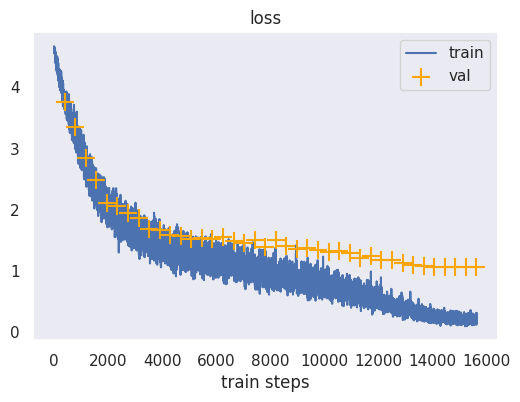

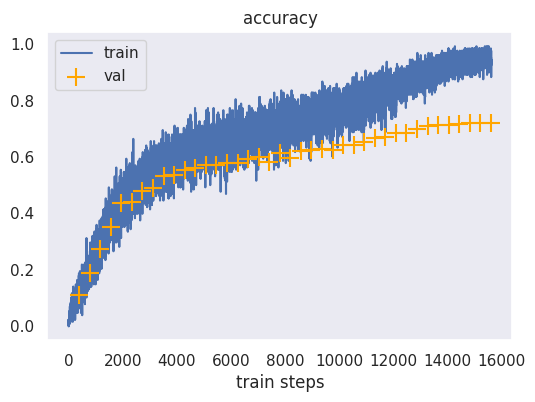

Epoch 39 valid accuracy = 71.98%
Accuracy: 71.98%


In [11]:
set_random_seed(42)

lr = 5e-2
num_epochs = 40

model0 = ResNet(config)
model0.to(device)
optim = torch.optim.SGD(model0.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model0, optim, scheduler)
torch.save(model0.state_dict(), checkpoint_dir + "/cifar100_smallresnet0.pth")

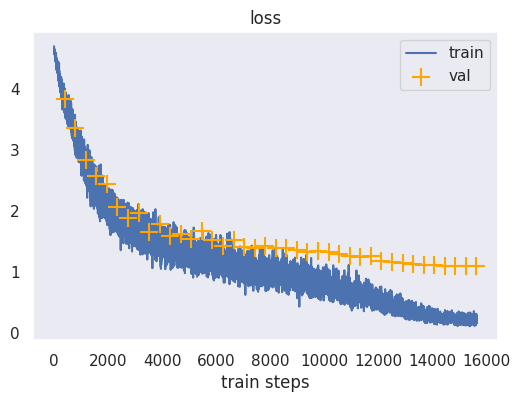

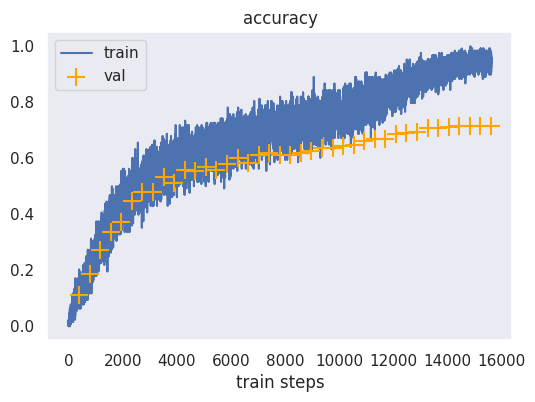

Epoch 39 valid accuracy = 71.46%
Accuracy: 71.46%


In [12]:
set_random_seed(92)

lr = 5e-2
num_epochs = 40

model1 = ResNet(config)
model1.to(device)
optim = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model1, optim, scheduler)
torch.save(model1.state_dict(), checkpoint_dir + "/cifar100_smallresnet1.pth")

## Permute the weights of model 0 to align with model 1

In [13]:
from tqdm.auto import tqdm

def get_interpolation(model0, model1, alphas = np.linspace(0, 1, 25),
                      repair = "none", loader = None):
    if loader is None:
        loader = testloader
    
    accuracies = []
    losses = []
    for alpha in tqdm(alphas, desc="Interpolate"):
        interpolated = interpolate(model0, model1, alpha)
        if repair == "closed":
            repair_closed(model0, model1, interpolated, alpha)
        elif repair == "trainmode":
            repair_trainmode(interpolated)
        elif repair == "sphere":
            repair_sphere(model0, model1, interpolated, alpha)
        loss, accuracy = test(interpolated, loader)
        accuracies += [accuracy]
        losses += [loss]
        
        del interpolated

    return accuracies, losses, alphas

def get_variance(model):
    return np.array([
        module.var.mean().item() for module in model.modules.values()
    ], dtype=float)

def reload_models():
    global model0, model1
    
    model0 = ResNet(config)
    model0.load_state_dict(torch.load(checkpoint_dir + f"/{save_name}0.pth"))
    model1 = ResNet(config)
    model1.load_state_dict(torch.load(checkpoint_dir + f"/{save_name}1.pth"))

    model0.to(device)
    model1.to(device)

### CIFAR100

### ResNet

In [14]:
config = CIFARResNetConfig()
perm_spec = resnet18_permutation_spec()
dataset_name = "cifar100"
model_type = "smallresnet"
save_name = f"{dataset_name}_{model_type}"

In [15]:
reload_models()
accs, losses, alphas = get_interpolation(model0, model1)
accs_tr, losses_tr, _ = get_interpolation(model0, model1, repair="trainmode")
# accs_sph, losses_sph, _ = get_interpolation(model0, model1, repair="sphere")
# collect_statistics([model0, model1], full=True)
# accs_rep, losses_rep, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1

reload_models()
with Timer("activation matching, total"):
    with Timer("activation matching, collect stats"):
        collect_statistics([model0, model1], full=True)
    with Timer("activation matching"):
        match_activations(model0, model1, perm_spec)
# post_act_accs, post_act_losses, _ = get_interpolation(model0, model1)
post_act_tr_accs, post_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# post_act_sph_accs, post_act_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
# post_act_rep_accs, post_act_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1

reload_models()
with Timer("weight matching"):
    match_weights(model0, model1, perm_spec, normalize=False)
# weight_accs, weight_losses, _ = get_interpolation(model0, model1)
weight_tr_accs, weight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# weight_sph_accs, weight_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
# collect_statistics([model0, model1], full=True)
# weight_rep_accs, weight_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1

# reload_models()
# match_weights(model0, model1, perm_spec, normalize=True)
# weightn_tr_accs, weightn_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

# del model0
# del model1

# config.matching_mode = "pre_activation"
# reload_models()
# collect_statistics([model0, model1], full=True)
# match_activations(model0, model1, perm_spec)
# pre_act_accs, pre_act_losses, _ = get_interpolation(model0, model1)
# pre_act_tr_accs, pre_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# pre_act_sph_accs, pre_act_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
# pre_act_rep_accs, pre_act_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

# del model0
# del model1

reload_models()
with Timer("sinkhorn weight matching"):
    match_weights_sinkhorn(model0, model1, perm_spec, normalize=False)
# sweight_accs, sweight_losses, _ = get_interpolation(model0, model1)
sweight_tr_accs, sweight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

del model0
del model1

# reload_models()
# match_weights_sinkhorn(model0, model1, perm_spec, normalize=True)
# sweightn_accs, sweightn_losses, _ = get_interpolation(model0, model1)
# sweightn_tr_accs, sweightn_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

# del model0
# del model1

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

activation matching, collect stats: 12 s 570 ms
activation matching: 3 s 6 ms
activation matching, total: 15 s 577 ms


Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

weight matching: 150 ms


Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration 00: training loss 0.042, validation loss 0.059
Iteration 01: training loss 0.040, validation loss 0.059
Iteration 02: training loss 0.039, validation loss 0.059
Iteration 03: training loss 0.037, validation loss 0.059
Iteration 04: training loss 0.036, validation loss 0.059
Iteration 05: training loss 0.035, validation loss 0.050
Iteration 06: training loss 0.034, validation loss 0.048
Iteration 07: training loss 0.033, validation loss 0.047
Iteration 08: training loss 0.032, validation loss 0.046
Iteration 09: training loss 0.032, validation loss 0.046
Iteration 10: training loss 0.031, validation loss 0.045
Iteration 11: training loss 0.030, validation loss 0.043
Iteration 12: training loss 0.030, validation loss 0.043
Iteration 13: training loss 0.029, validation loss 0.042
Iteration 14: training loss 0.029, validation loss 0.042
Iteration 15: training loss 0.028, validation loss 0.041
Iteration 16: training loss 0.028, validation loss 0.040
Iteration 17: training loss 0.0

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Direct

In [16]:
reload_models()
with Timer("sinkhorn direct"):
    sinkhorn_direct(model0, model1, perm_spec, repair="trainmode")
# sweight_accs, sweight_losses, _ = get_interpolation(model0, model1)
sdirect_tr_accs, sdirect_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

Iteration 00: training loss 1.420, validation loss 1.259
Iteration 01: training loss 0.778, validation loss 1.825
Iteration 02: training loss 0.777, validation loss 1.591
Iteration 03: training loss 0.791, validation loss 2.268
Iteration 04: training loss 0.782, validation loss 1.616
Iteration 05: training loss 0.776, validation loss 1.245
Iteration 06: training loss 0.738, validation loss 2.123
Iteration 07: training loss 0.775, validation loss 1.245
Iteration 08: training loss 0.787, validation loss 1.244
Iteration 09: training loss 0.822, validation loss 1.247
Iteration 10: training loss 0.761, validation loss 1.247
Iteration 11: training loss 0.815, validation loss 1.519
Iteration 12: training loss 0.778, validation loss 1.254
Iteration 13: training loss 0.860, validation loss 1.972
Iteration 14: training loss 0.803, validation loss 1.356
Iteration 15: training loss 0.829, validation loss 1.495
Iteration 16: training loss 0.817, validation loss 1.568
Iteration 17: training loss 0.7

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

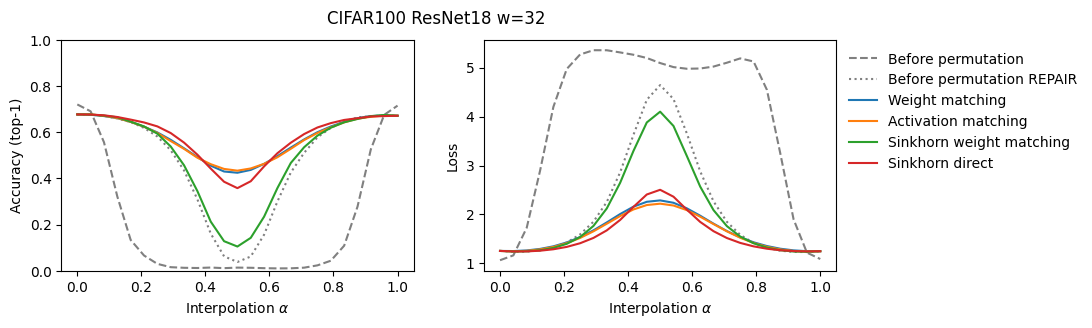

In [17]:
sns.reset_orig()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(alphas, accs, label="Before permutation", linestyle="--", color="grey")
axes[0].plot(alphas, accs_tr, label="Before permutation REPAIR", linestyle=":", color="grey")
axes[0].plot(alphas, weight_tr_accs, label="Weight matching")
axes[0].plot(alphas, post_act_tr_accs, label="Activation matching")
axes[0].plot(alphas, sweight_tr_accs, label="Sinkhorn weight matching")
axes[0].plot(alphas, sdirect_tr_accs, label="Sinkhorn direct")
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("Interpolation $\\alpha$")
axes[0].set_ylabel("Accuracy (top-1)")
# axes[0].legend(bbox_to_anchor=(1, 1), frameon=False)

axes[1].plot(alphas, losses, label="Before permutation", linestyle="--", color="grey")
axes[1].plot(alphas, losses_tr, label="Before permutation REPAIR", linestyle=":", color="grey")
axes[1].plot(alphas, weight_tr_losses, label="Weight matching")
axes[1].plot(alphas, post_act_tr_losses, label="Activation matching")
axes[1].plot(alphas, sweight_tr_losses, label="Sinkhorn weight matching")
axes[1].plot(alphas, sdirect_tr_losses, label="Sinkhorn direct")
axes[1].set_xlabel("Interpolation $\\alpha$")
axes[1].set_ylabel("Loss")
axes[1].legend(bbox_to_anchor=(1, 1), frameon=False)

plt.suptitle("CIFAR100 ResNet18 w=32")
plt.savefig(f"pics/new_{save_name}.pdf", bbox_inches="tight")
plt.show()